# Detector for Evasion Attack

---

## Binary Input Detector

### API Reference:
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/detector_evasion.html#binary-input-detector

### Description
This method is to detect of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.

---

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART
tf.get_logger().setLevel('ERROR')

import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from tensorflow.keras import datasets, layers, models, Sequential

import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from art.utils import load_dataset
from art.estimators.classification import KerasClassifier
from art.defences.detector.evasion.detector import BinaryInputDetector

cifar_model_path = '/archive/workspace/TTA/demo/models/baisc_cnn_cifar'

### Load dataset (CIFAR-10)

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 100
num_samples_test = 100
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Load trained model and evaluate model 

In this example, we use trained model which trained on the CIFAR-10 dataset. 

In [3]:
trained_model = models.load_model(cifar_model_path)
trained_model.summary()

2021-12-21 13:16:01.492390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:16:01.492969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:16:01.496771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:16:01.497321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:16:01.497787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0

In [4]:
from art.estimators.classification import KerasClassifier

classifier = KerasClassifier(clip_values=(min_, max_), model=trained_model, use_logits=False, 
                             preprocessing=(0.5, 1))

In [5]:
loss_test, accuracy_test = trained_model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2021-12-21 13:16:03.036261: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Accuracy on test data: 81.00%


In [6]:
x_test_pred = np.argmax(trained_model.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 81
Incorrectly classified: 19


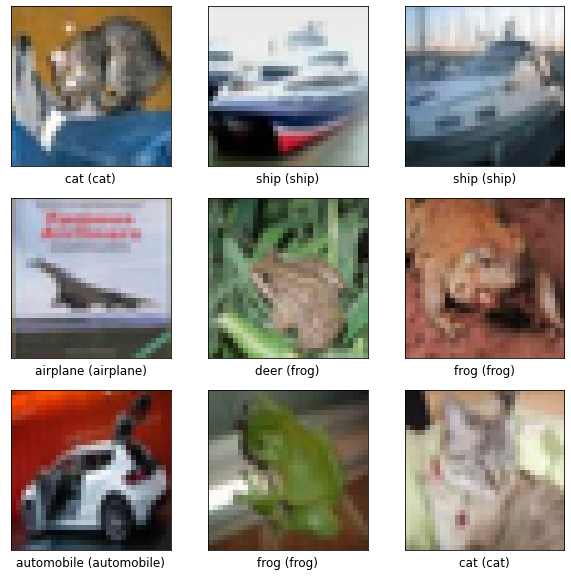

In [7]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

### Generate adversarial samples

Generate adversarial examples using fast gradient method

In [8]:
from art.attacks.evasion import FastGradientMethod

attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:100]) # this takes about two minutes


Evaluate the model on the adversarial smapels

In [9]:
x_test_adv_pred = np.argmax(trained_model.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 53
Incorrectly classified: 47


The number of correctly classifiered results is decreased from 80 to 53. 

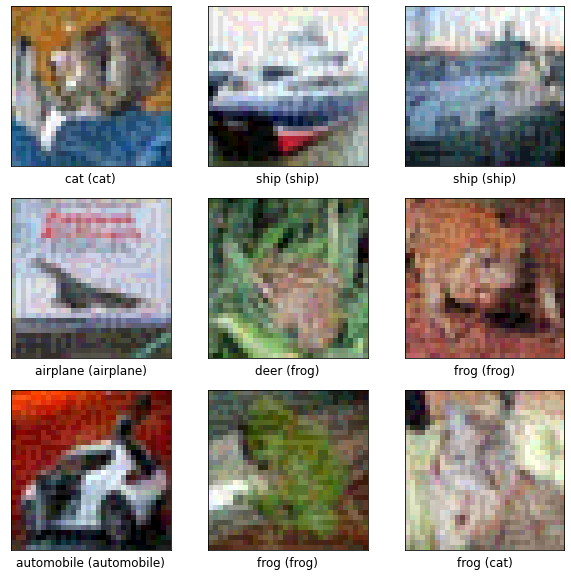

In [10]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

### Train the binary input detector

Load the detector model (provided by ART)

In [11]:
from art.utils import get_file
from art import config
from keras.models import load_model

path = get_file('BID_eps=0.05.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')

detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

To train the detector:
- we expand our training set with _adversarial samples_
- we label the data with 0 (original) and 1 (adversarial)

In [12]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

In [13]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20)

Train on 200 samples
Epoch 1/20
200/200 [==============================] - 3s 14ms/sample - loss: 0.0060 - accuracy: 1.0000
Epoch 2/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0060 - accuracy: 1.0000
Epoch 3/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0517 - accuracy: 0.9900
Epoch 4/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0075 - accuracy: 1.0000
Epoch 5/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0059 - accuracy: 1.0000
Epoch 6/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0082 - accuracy: 1.0000
Epoch 7/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0080 - accuracy: 1.0000
Epoch 8/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0055 - accuracy: 1.0000
Epoch 9/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.0060 - accuracy: 1.0000
Epoch 10/20
200/200 [==============================] - 0s 2m

## Evalute the detector 

Apply the detector to the adversarial test data and original test image in first 100.

If the detector detects a adversarial example, it returns 1.

In [14]:
flag_adv = np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0


In [15]:
flag_original = np.sum(np.argmax(detector.predict(x_test[:100]), axis=1) == 1)

print(detector.predict(x_test[:100])[0])


print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

[3.2521268e-05 9.9996746e-01]
Original test data (first 100 images):
Flagged: 99
Not flagged: 1


Evaluate the detector for different attack strengths `eps`

(**Note**: for the training of detector, `eps=0.05` was used)

In [16]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    nb_flag_adv += [np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]
    
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

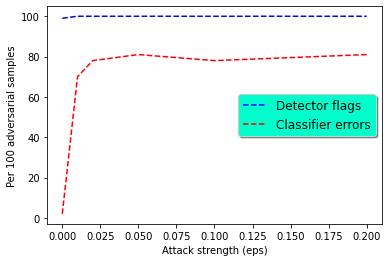

In [17]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()